In [11]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

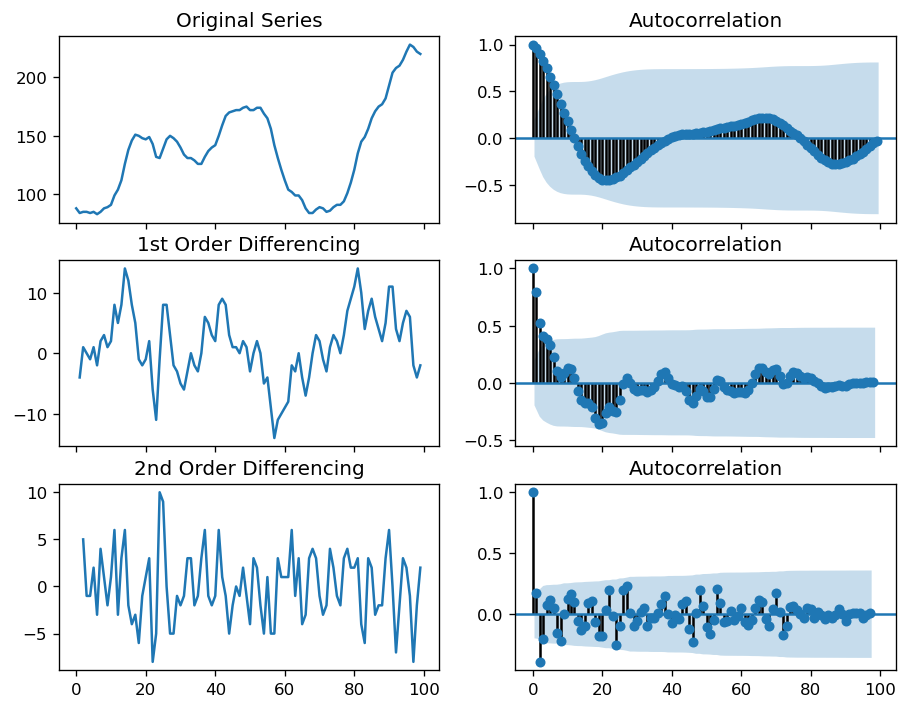

In [38]:
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags = 99)

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1],  lags = 98)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags = 97)

plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


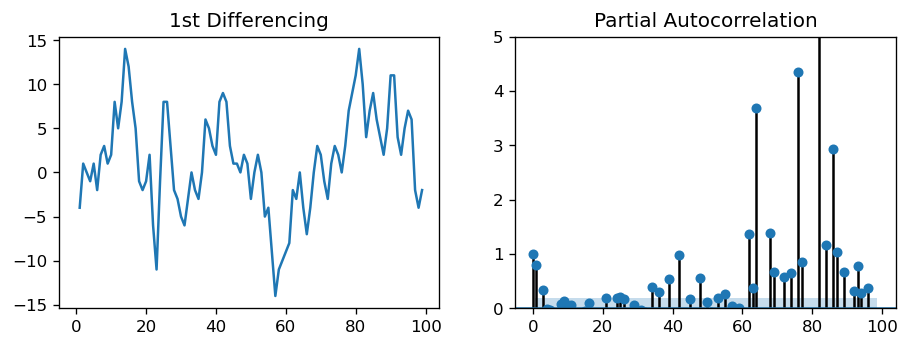

In [43]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1], lags = 98)

plt.show()

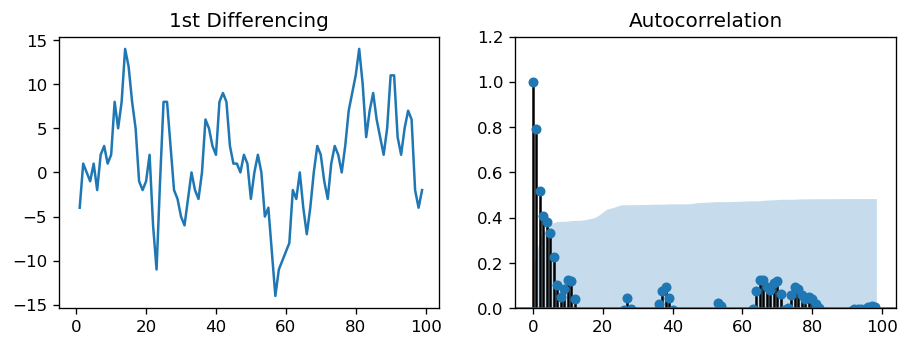

In [45]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1], lags = 98)

plt.show()

In [46]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 12 Aug 2021   AIC                            517.579
Time:                        12:09:50   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.value     0.5287      0.355     

In [47]:
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 12 Aug 2021   AIC                            515.579
Time:                        12:10:23   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

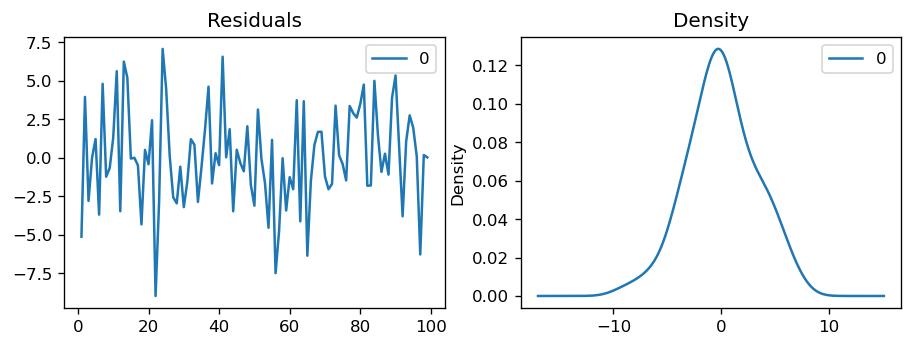

In [48]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

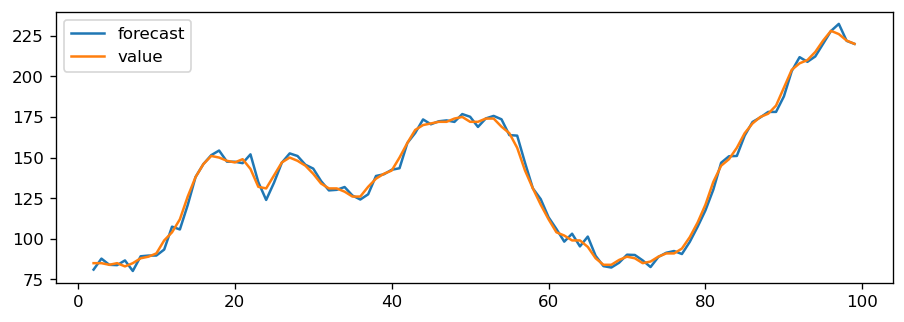

In [49]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [50]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

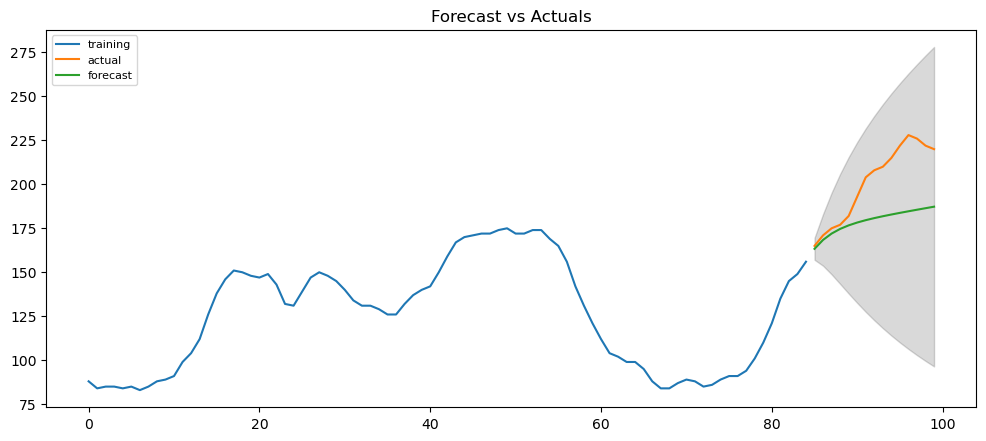

In [51]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [52]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.10300896376189865,
 'me': -22.120308894997418,
 'mae': 22.120308894997418,
 'mpe': -0.10300896376189865,
 'rmse': 26.755411919516767,
 'acf1': 0.8749545387739799,
 'corr': 0.9497235193717875,
 'minmax': 0.1030089637618985}

In [53]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

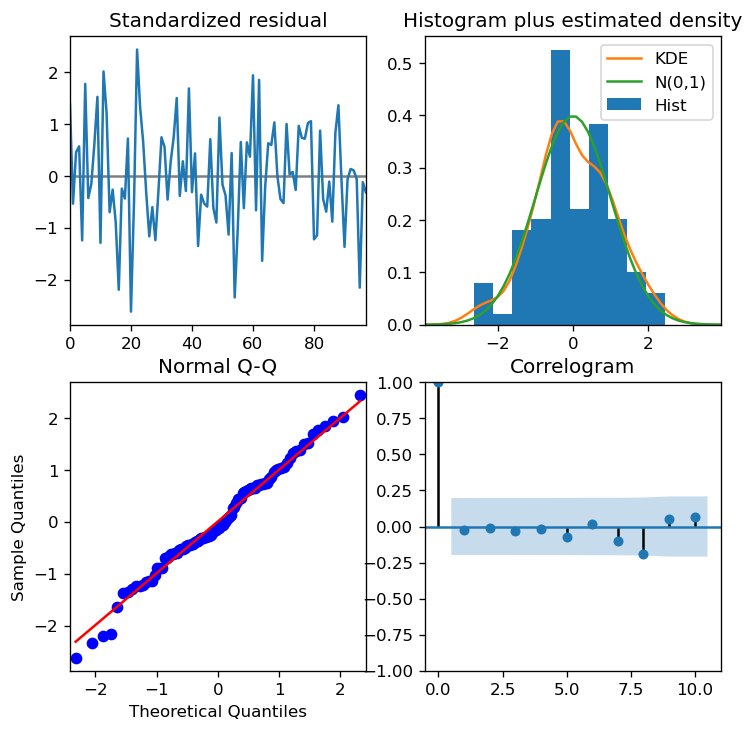

In [55]:
model.plot_diagnostics(figsize=(7,7))
plt.show()

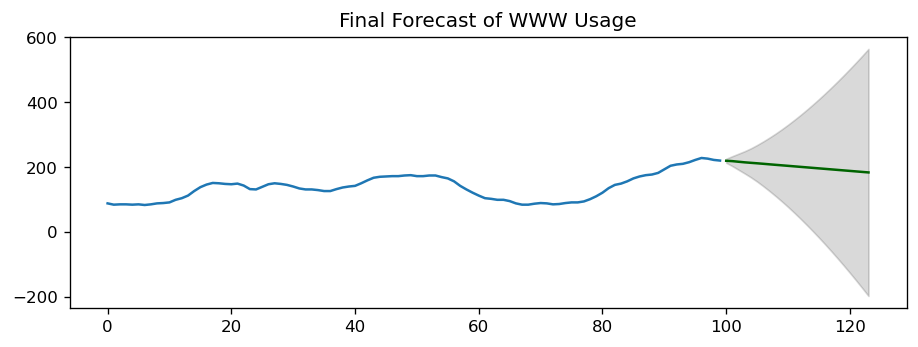

In [56]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()